In [1]:
#Objective:
# val acc ~72% normally on a small dataset
#To counter over-fitting, use dropout (?), weight decay (L2 regularization) and data augmentation
# val acc due to drop out and augmentation increased to ~82
# next to further improve: use a pre-trained convnet model!
# A pre-trained model, trained on a larger set. A generic model develops features that can
#be used even on a small data problem
#2 ways to use it: 1) feature extraction 2 options 2) fine-tuning
#we are using VGG16 pre-trained model architechture (ResNet, Inception, Xception etc are others)

In [10]:
#System Check
import sys;print('python version:',sys.version) 
import tensorflow as tf;print('tf_version:',tf.__version__) #tf: 2.1 
from tensorflow import keras; print('keras version:',keras.__version__) 
import keras 
print("keras version on its own:",keras.__version__) #tf keras and keras library can have different versions
from tensorflow.python.platform import build_info as tf_build_info 
#print('CUDA Version:',tf_build_info.cuda_version_number) 
#print('CUDNN Version:',tf_build_info.cudnn_version_number)

import tensorflow as tf
tf.test.is_gpu_available() # True/False
print("GPU Status:",tf.test.is_gpu_available())

#Releases the python gpu memory
from numba import cuda
cuda.select_device(0)
cuda.close()

"""
# Or only check for gpu's with cuda support
tf.test.is_gpu_available(cuda_only=True) 
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
"""

python version: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
tf_version: 1.12.0
keras version: 2.1.6-tf
keras version on its own: 2.1.6
GPU Status: True


"\n# Or only check for gpu's with cuda support\ntf.test.is_gpu_available(cuda_only=True) \nfrom tensorflow.python.client import device_lib\nprint(device_lib.list_local_devices())\n"

In [11]:
# Feature Extaction#######
#representations learned by a previous network to extract interesting features 
#from new samples. This is then run through a new classifier
#Old conv base + New Classifier
# Key concept: Since representations of the 1st few layers are local, non-generic features
# so we don't use the first few layers or the top and use higher generic layers only

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, #this is the classifer that we dont use; also image net classifier has 1000 categories whereas we only have 1
                  input_shape=(150, 150, 3)) #optional; it can process any size

In [12]:
conv_base.summary()
#the final feature map has shape 4,4,512 on top of which we will connect desely-connected classifier

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
#The final feature map has shape (4, 4, 512). That's the feature on top of which we will stick a densely-connected classifier.
#2 options:

# Option 1)
# Run conv base over each image once >store output on numpy >connect it to classifier
#Good: runs expensive conv base 1
#Bad: does not allow data augmentation

#Option 2
#Conv base + classifier (dense layer) on each image. Allows data aug
#computationally expensive

#####option 1####
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/oj/Downloads/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
#The extracted features are currently of shape (samples, 4, 4, 512). We will feed them to a densely-connected classifier, 
#so first we must flatten them to (samples, 8192):
#4*4*512

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [10]:
#At this point, we can define our densely-connected classifier (note the use of dropout for regularization), 
#and train it on the data and labels that we just recorded:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 430us/step - loss: 0.5914 - acc: 0.6725 - val_loss: 0.4330 - val_acc: 0.8470
Epoch 2/30
2000/2000 [==============================] - 1s 285us/step - loss: 0.4119 - acc: 0.8140 - val_loss: 0.3519 - val_acc: 0.8680
Epoch 3/30
2000/2000 [==============================] - 1s 317us/step - loss

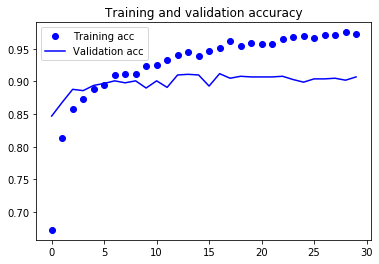

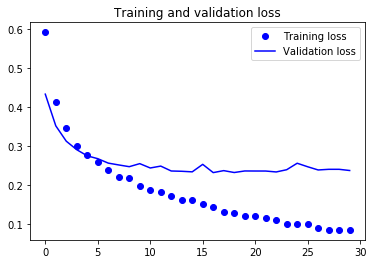

In [11]:
#Training is very fast, since we only have to deal with two Dense layers -- an epoch takes less than one second even on CPU.
#Let's take a look at the loss and accuracy curves during training

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Accuracy is over 90% but we are over-fitting
#data aug is not used

In [6]:
#Option2 - W Data Aug -only attempt if there is a gpu
#Because models behave just like layers, you can add a model (like our conv_base) to a Sequential model just like you would add a layer. 
#So you can do the following:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.
/home/oj/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/oj/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/oj/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/oj/anaconda3/lib/python3.6/site-packages/tensorflow/python/fra

NameError: name 'conv_base' is not defined

In [ ]:
#As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 million parameters.
#Before we compile and train our model, 
#a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False #in keras, that is how you freeze it


print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 20s - loss: 0.5869 - acc: 0.7005 - val_loss: 0.4584 - val_acc: 0.8150
Epoch 2/30
 - 20s - loss: 0.4880 - acc: 0.7740 - val_loss: 0.3793 - val_acc: 0.8540
Epoch 3/30
 - 20s - loss: 0.4342 - acc: 0.8040 - val_loss: 0.3409 - val_acc: 0.8620
Epoch 4/30
 - 20s - loss: 0.4110 - acc: 0.8200 - val_loss: 0.3178 - val_acc: 0.8730
Epoch 5/30
 - 20s - loss: 0.3759 - acc: 0.8420 - val_loss: 0.3051 - val_acc: 0.8780
Epoch 6/30
 - 20s - loss: 0.3701 - acc: 0.8360 - val_loss: 0.2856 - val_acc: 0.8900
Epoch 7/30
 - 20s - loss: 0.3559 - acc: 0.8415 - val_loss: 0.2806 - val_acc: 0.8900
Epoch 8/30
 - 20s - loss: 0.3534 - acc: 0.8365 - val_loss: 0.2698 - val_acc: 0.9000
Epoch 9/30
 - 20s - loss: 0.3416 - acc: 0.8595 - val_loss: 0.2662 - val_acc: 0.8950
Epoch 10/30
 - 20s - loss: 0.3455 - acc: 0.8485 - val_loss: 0.2610 - val_acc: 0.8940
Epoch 11/30
 - 20s - loss: 0.3395 - acc: 0.8445 - val_loss: 0.2585 - val_ac

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

In [15]:
model.save('cats_and_dogs_small_3.h5')

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
#As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

NameError: name 'history' is not defined

In [20]:
#Fine-tuning Way

# Feature Extaction#######
#representations learned by a previous network to extract interesting features 
#from new samples. This is then run through a new classifier
#Old conv base + New Classifier
# Key concept: Since representations of the 1st few layers are local, non-generic features
# so we don't use the first few layers or the top and use higher generic layers only

#In feature extraction: conv base was frozen while dense layers were trainable. 
#While in fine tuning, some part of conv base is unfrozen. This unfrozen conv base + dense layers are trained together


from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False, #this is the classifer that we dont use; also image net classifier has 1000 categories whereas we only have 1
                  input_shape=(150, 150, 3)) #optional; it can process any size
#Conv base looks like the following
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [21]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [22]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [25]:
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/oj/Downloads/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 27s 273ms/step - loss: 0.5309 - acc: 0.7425 - val_loss: 0.3291 - val_acc: 0.8590
Epoch 2/100
100/100 [==============================] - 24s 242ms/step - loss: 0.3642 - acc: 0.8460 - val_loss: 0.2444 - val_acc: 0.8920
Epoch 3/100
100/100 [==============================] - 24s 238ms/step - loss: 0.3262 - acc: 0.8680 - val_loss: 0.2219 - val_acc: 0.9080
Epoch 4/100
100/100 [==============================] - 25s 248ms/step - loss: 0.2831 - acc: 0.8820 - val_loss: 0.2394 - val_acc: 0.8990
Epoch 5/100
100/100 [==============================] - 25s 248ms/step - loss: 0.2613 - acc: 0.8945 - val_loss: 0.1910 - val_acc: 0.9160
Epoch 6/100
100/100 [==============================] - 25s 246ms/step - loss: 0.2479 - acc: 0.9025 - val_loss: 0.1823 - val_acc: 0.9220
Epoch 7/100
100/100 [==============================] - 26s 256ms/step - loss: 0.2286 - acc: 0.9040 - val_loss: 0.2163 - val_acc: 0.9080
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 26s 255ms/step - loss: 0.0453 - acc: 0.9810 - val_loss: 0.1953 - val_acc: 0.9400
Epoch 62/100
100/100 [==============================] - 24s 243ms/step - loss: 0.0447 - acc: 0.9830 - val_loss: 0.1941 - val_acc: 0.9430
Epoch 63/100
100/100 [==============================] - 24s 243ms/step - loss: 0.0508 - acc: 0.9775 - val_loss: 0.1850 - val_acc: 0.9420
Epoch 64/100
100/100 [==============================] - 24s 244ms/step - loss: 0.0443 - acc: 0.9855 - val_loss: 0.2006 - val_acc: 0.9410
Epoch 65/100
100/100 [==============================] - 24s 243ms/step - loss: 0.0295 - acc: 0.9890 - val_loss: 0.1967 - val_acc: 0.9430
Epoch 66/100
100/100 [==============================] - 25s 249ms/step - loss: 0.0424 - acc: 0.9850 - val_loss: 0.1979 - val_acc: 0.9430
Epoch 67/100
100/100 [==============================] - 24s 243ms/step - loss: 0.0307 - acc: 0.9885 - val_loss: 0.1874 - val_acc: 0.9430
Epoch 68/100
100/100 [===================

In [27]:
model.save('cats_and_dogs_small_4.h5')

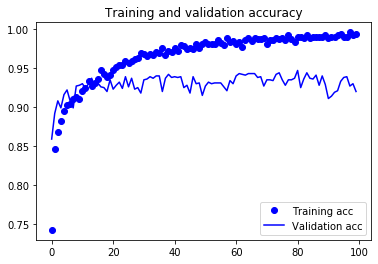

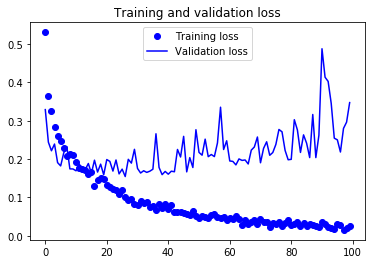

In [29]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

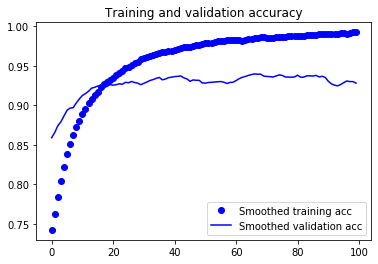

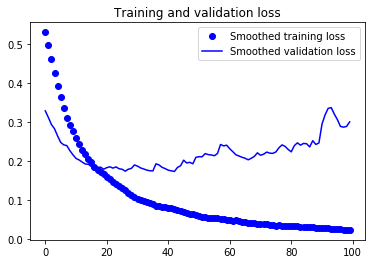

In [30]:
#making above graphs smoother. This is done by replacing every loss and accuracy with exponential moving averages
#This is for readability

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Found 1000 images belonging to 2 classes.
test acc: 0.931999990940094
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


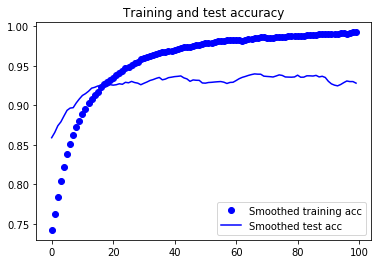

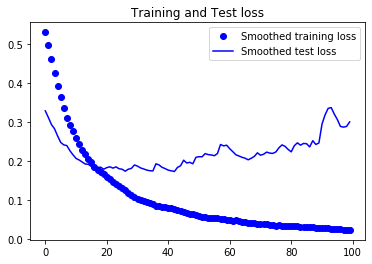

In [42]:
#finally on test data
import matplotlib.pyplot as plt

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

#####################################
####My own test acc printing#####

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

test2_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')



acc = history.history['acc']
test2_acc = history.history['val_acc'] #test_acc is in model.evaluate but you can plot it using the val_Acc and pointing it to the test_dir
loss = history.history['loss']
test2_loss = history.history['val_loss']

epochs = range(len(acc))

"""
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Test and Test loss')
plt.legend()

plt.show()
"""

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(test2_acc), 'b', label='Smoothed test acc')
plt.title('Training and test accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(test2_loss), 'b', label='Smoothed test loss')
plt.title('Training and Test loss')
plt.legend()

plt.show()

In [ ]:
"""
Take-aways: using convnets with small datasets
Here's what you should take away from the exercises of these past two sections:

Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very small dataset, with decent results.
On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image data.
It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with small image datasets.
As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.
Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.